# Using quantile regression as uncertainty surrogate

Usually, Bayesian models such as Gaussian processes are used to determine uncertainty intervalls. But there are many other techniques that can be used as uncertainty surrogates. For example, PyPAL implements [quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) using [Gradient Boosted Decision trees](https://en.wikipedia.org/wiki/Gradient_boosting).

As in the other examples, we will use the [Binh-Korn test function](https://en.wikipedia.org/wiki/Test_functions_for_optimization).

In [1]:
from pypal.models.gbdt import build_gbdt_tuple
from pypal import PALGBDT
from pypal.pal.utils import exhaust_loop
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

In [2]:
def binh_korn(x, y):  # pylint:disable=invalid-name
    """https://en.wikipedia.org/wiki/Test_functions_for_optimization"""
    obj1 = 4 * x ** 2 + 4 * y ** 2
    obj2 = (x - 5) ** 2 + (y - 5) ** 2
    return -obj1, -obj2

def binh_korn_points():
    """Create a dataset based on the Binh-Korn test function"""
    x = np.linspace(0, 5, 100)  # pylint:disable=invalid-name
    y = np.linspace(0, 3, 100)  # pylint:disable=invalid-name
    array = np.array([binh_korn(xi, yi) for xi, yi in zip(x, y)])
    return np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)]), array

In [3]:
x, points = binh_korn_points()

Again, we can start by plotting our objective space.

Text(0, 0.5, 'objective 2')

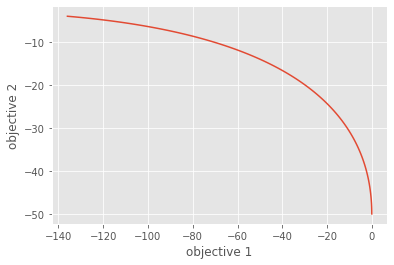

In [4]:
plt.plot(points[:,0], points[:,1])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

## Building the models

PyPAL comes with helper functions to build the Gradient Boosted Decision Tree models.

In [86]:
objective_0_models = build_gbdt_tuple(n_estimators=50, num_leaves=10)
objective_1_models = build_gbdt_tuple(n_estimators=50, num_leaves=10)

## Initializing PyPAL

In [92]:
palinstance = PALGBDT(x, [objective_0_models, objective_1_models], 2, coef_var_threshold=10, beta_scale=1/50)

 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/PythonPAL/pypal/pal/validate_inputs.py:117: UserWarning:Only one epsilon value provided,
will automatically expand to use the same value in every dimension
 /Users/kevinmaikjablonka/Dropbox (LSMO)/Documents/open_source/PythonPAL/pypal/pal/validate_inputs.py:145: UserWarning:No goals provided, will assume that every dimension should be maximized


Before we can handover the work to a loop we need to initialize the `palinstance` with some measurement. Often, a diverse set is the best choice and PyPAL provides an utilities to calculate this set (`get_kmeans_samples`, `get_maxmin_samples`). Here, we will use a greedy sampling of the farthest points in design space, initialized with the mean and using the Euclidean distance as distance metric (these are the defaults).

In [93]:
from pypal import get_kmeans_samples

In [94]:
indices = get_kmeans_samples(x, 5)

In [95]:
palinstance.update_train_set(indices, points[indices])
palinstance.cross_validation_points = 0 # for performance reasons, we won't perform cross validation

## Now we can explore the space

To have some more custom control we will write our own loop, but we could also just use `exhaust_loop`.

In [96]:
while sum(palinstance.unclassified) > 0: 
    new_index = palinstance.run_one_step()
    print(palinstance) # the string representation of the object will give basic information about the state
    # if there is nothing to sample left, run_one_step() will return None
    if new_index is not None: 
        palinstance.update_train_set(new_index, points[new_index])
    else: 
        break

pypal at iteration 2.         0 Pareto optimal points,         0 discarded points,         100 unclassified points.
pypal at iteration 3.         0 Pareto optimal points,         0 discarded points,         100 unclassified points.
pypal at iteration 4.         1 Pareto optimal points,         0 discarded points,         99 unclassified points.
pypal at iteration 5.         2 Pareto optimal points,         0 discarded points,         98 unclassified points.
pypal at iteration 6.         2 Pareto optimal points,         0 discarded points,         98 unclassified points.
pypal at iteration 7.         3 Pareto optimal points,         0 discarded points,         97 unclassified points.
pypal at iteration 8.         3 Pareto optimal points,         0 discarded points,         97 unclassified points.
pypal at iteration 9.         3 Pareto optimal points,         0 discarded points,         97 unclassified points.
pypal at iteration 10.         4 Pareto optimal points,         0 discarded po